## Lecture 11


   

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal


import numpy as np
from numpy import arange,linspace,mean, var, std, corrcoef, transpose, ones,log
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
from numpy.random import seed,random, randint, uniform
import math
from collections import Counter
import pandas as pd

#.  %matplotlib qt


# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)    
    

In [2]:
# create a dictionary of piano key frequencies

# see https://en.wikipedia.org/wiki/Piano_key_frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C4']

261.62556530059896

In [3]:
# some useful spectra    

def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []
    
# example

makeSpectrum('triangle',1000)

[(1000, 1.0, 0.0),
 (3000, -0.1111111111111111, 0.0),
 (5000, 0.04, 0.0),
 (7000, -0.02040816326530612, 0.0),
 (9000, 0.012345679012345678, 0.0),
 (11000, -0.008264462809917356, 0.0),
 (13000, 0.005917159763313609, 0.0)]

In [4]:
def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X    

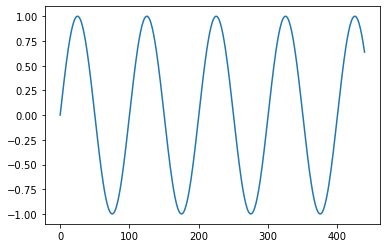

In [7]:
# to generate a signal W samples long with frequency f:

SR = 22050
W = 441             # W/SR = 0.2 seconds long with sample rate SR = 22050
T = np.arange(W)    # sample numbers
f = 220

# list comprehension (ok)

x = np.array( [ np.sin(2*np.pi*f*t/SR) for t in T] ) 

# applying scalar functions to an array (better)
      
X = np.sin(2*np.pi*f*T/SR) 
plt.plot(x)
plt.show()

## Librosa 

Please consult the useful tutorial here for additional information about using `librosa` and `IPython.display.Audio`:

https://musicinformationretrieval.com/ipython_audio.html

Complete librosa docs are here:

https://librosa.org/doc/latest/index.html 

### Reading audio files

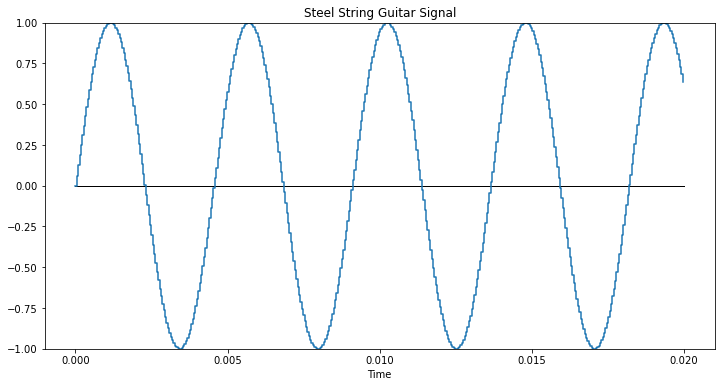

/Users/waynesnyder/opt/anaconda3/envs/tensorflo_environment/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=441
  warnings.warn(


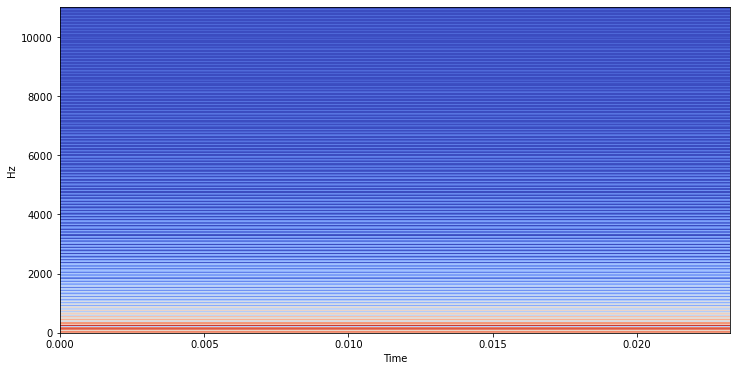

In [9]:
# display the waveform

def displaySignal(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.0,1.0])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()

# display the spectrogram

def displaySpectrogram(x,sr=SR,title='Signal X'):
    S = librosa.stft(x)
    Sdb = librosa.amplitude_to_db(abs(S))
    plt.figure(figsize=(12,6))
    librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='hz')
    #plt.colorbar()
    plt.show()

    
displaySignal(x,SR,"Steel String Guitar Signal") 

displaySpectrogram(x,SR,"Spectrogram for Steel String Guitar Signal")

Here is another way to show a spectrogram, using `matplotlib` built-in `specgram`:

<ipython-input-10-8066f402115d>:3: UserWarning: Only one segment is calculated since parameter NFFT (=1024) >= signal length (=441).
  plt.specgram(x, NFFT=1024,Fs=SR)


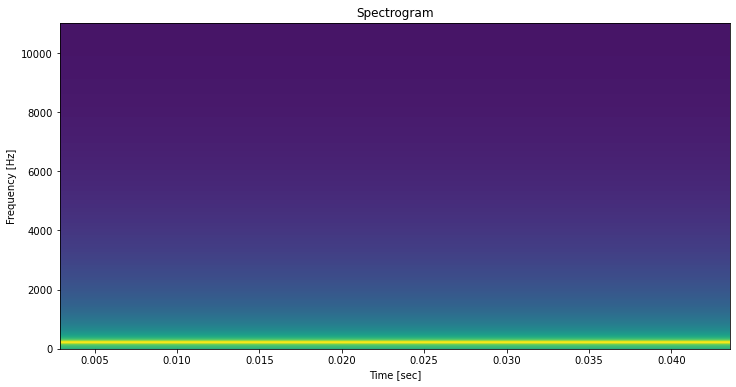

In [10]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram')
plt.specgram(x, NFFT=1024,Fs=SR)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

###  Displaying Instantaneous Spectra

Matplotlib has a useful function to display a spectrum for the whole signal; by giving it
a short "window" you can get the same information contained in one column of the spectrogram:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


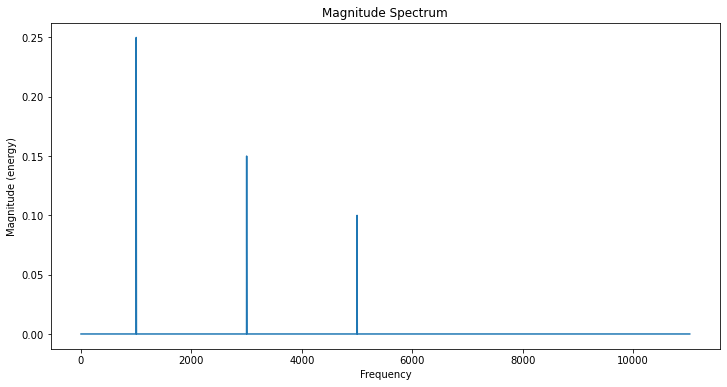

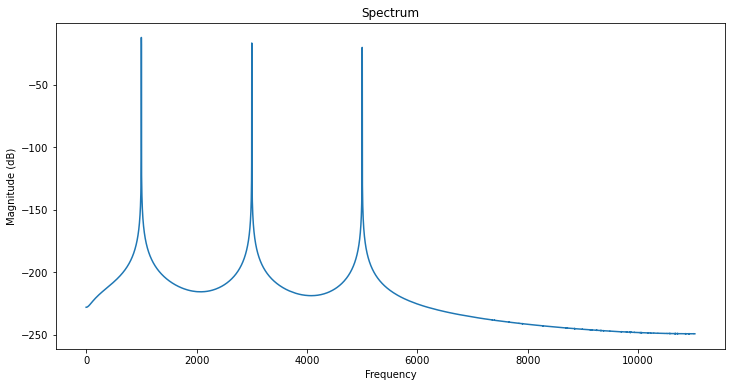

In [13]:
# Example: Create a signal with a simple spectrum

SR = 22050
f = 220
T = np.arange(SR*1)
X = 0.5 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 0.3 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 0.2 * np.sin( 2 * np.pi * 5000 * T / SR )

plt.figure(figsize=(12,6))
plt.title("Magnitude Spectrum")
plt.magnitude_spectrum(X,SR)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

22050
44100


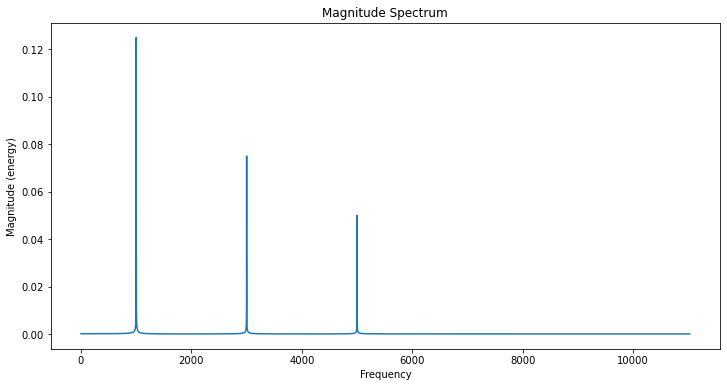

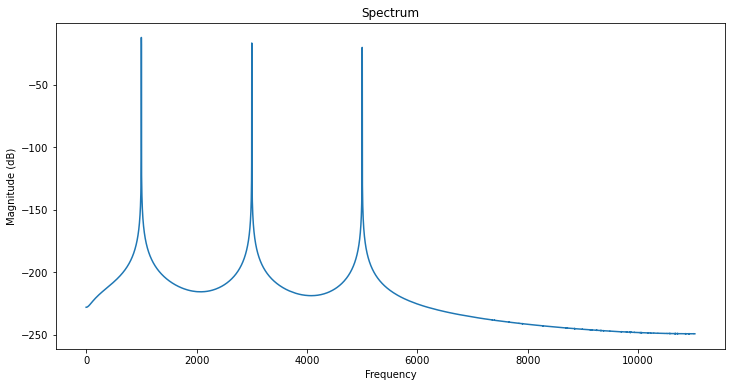

990 	 4.042626455399746e-16
991 	 0.00025125204977471943
992 	 7.075219967458877e-16
993 	 0.0002515339711764383
994 	 2.0314733506021573e-15
995 	 0.0002518171962936174
996 	 1.753992709236954e-15
997 	 0.00025210173250224914
998 	 8.821931024419926e-16
999 	 0.00025238758722806
1000 	 9.898651944319489e-16
1001 	 0.0002526747679623359
1002 	 1.7308320886303223e-15
1003 	 0.0002529632822533993
1004 	 2.1919222456673056e-15
1005 	 0.0002532531377150346
1006 	 8.458948192194013e-16
1007 	 0.0002535443420250307
1008 	 5.856060297498424e-16
1009 	 0.0002538369029180121


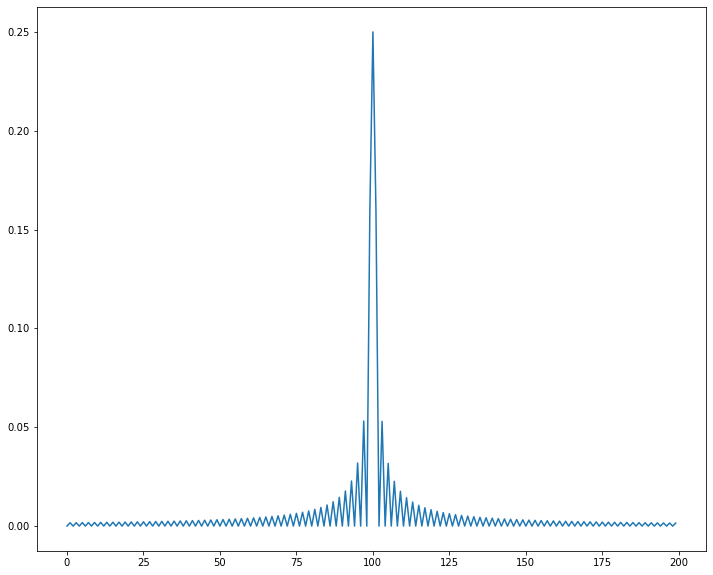

In [31]:
X1 = np.concatenate([X,np.zeros(len(X))])
print(len(X))
print(len(X1))

plt.figure(figsize=(12,6))
plt.title("Magnitude Spectrum")
plt.magnitude_spectrum(X1,SR)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

S1 = realFFT(X1)
for k in range(990,1010):
    print(k,"\t",S1[k])

plt.figure(figsize=(12,10))
plt.plot(S1[1900:2100])



In [12]:
# You can also get the spectrum from the function using the Fast Fourier Transform, which
# we will study in some detail in the second part of the course. For now, we will use it to extract
# a spectrum from a signal.  This is just a wrapper around numpy fft to produce a real spectrum

# If the signal array is X, with len(X) number of samples, of duration D = len(X)/SR seconds, 
# the list returned is the amplitude of sine waves of frequency 0, 1/D, 2/D, 3/D, ..., SR/2 (the Nyquist limit)
# and the length of the list is len(X)/2 + 1. So each "frequency bin" at index k has the amplitude of
# the frequency k/D. 



def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

T = np.arange(SR*1)    # duration = 1 sec
X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )

displaySpectrum(X)
Audio(X,rate=SR)


NameError: name 'displaySpectrum' is not defined

In [ ]:

T = np.arange(SR*1)    # duration = 1 sec
X = 10000 * np.sin( 2 * np.pi * 220 * T / SR )
X += 5000 * np.sin( 2 * np.pi * 440 * T / SR )
X += 2500 * np.sin( 2 * np.pi * 880 * T / SR )

displaySpectrum(X)
Audio(X,rate=SR)

In [ ]:

T = np.arange(SR*1)    # duration = 1 sec
X = 10000 * np.sin( 2 * np.pi * 220 * T / SR  + np.pi)
X += 5000 * np.sin( 2 * np.pi * 440 * T / SR + 1.23)
X += 2500 * np.sin( 2 * np.pi * 880 * T / SR - 3.42)

displaySpectrum(X)
Audio(X,rate=SR)


In [ ]:
# We can also return a list of triples of form  [f, A, phi] for each frequency
# f detected by the transform, however, note that, due to floating-point error, 
# you will get extremely small values instead of 0.0 for most of the frequencies; 
# therefore allow the option of filtering out these values using np.isclose(...)

T = np.arange(SR*0.1)    # duration = 0.1 sec
SR = 22050
X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 

print(spectrumFFT(X))
print()
S = spectrumFFT(X,False)
print(S[:5])
print()
print(S[98:104])
print()
print(S[-5:])

## Lecture 11 material


In [ ]:
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

def displaySpectrum(X,sr=SR,title='Spectrum of X',xscale='linear',yscale='dB'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.magnitude_spectrum(X,sr,scale=yscale)
    if(xscale == 'linear'):
        plt.xlabel('Frequency (linear)')
    else:    
        plt.xlabel('Frequency (log)')
    if(yscale == 'linear'):
        plt.ylabel('Magnitude (linear)')
    else:    
        plt.ylabel('Magnitude (dB)')
    plt.xscale(xscale)
    plt.show()
    
    
# Example: Create a signal with a simple spectrum

SR = 22050
f = 220
T = np.arange(SR*1)
X = 0.5 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 0.3 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 0.2 * np.sin( 2 * np.pi * 5000 * T / SR )

S = makeSpectrum('organ',110)

X2 = makeSignal(S)

displaySignal(X2)

displaySignal(X2[:1000],title="Signal X[:1000]")

Audio(X2,rate=SR)

In [ ]:
X1, sr = librosa.load(librosa.ex('trumpet'))

plt.magnitude_spectrum(X1,sr,scale='linear')
plt.show()

plt.magnitude_spectrum(X2,sr,scale='dB')
plt.show()

In [ ]:

def realIFFT(S,A=None):
    S = np.array(S)
    lenX = 2*(len(S)-1)
    complex_S = lenX / 2 * -1.j * S
    X = np.fft.irfft(complex_S)
    if(A == None):
        return X
    else:
        return A * X / max(X)

In [ ]:
X, sr = librosa.load(librosa.ex('trumpet'))


displaySignal(X)
Audio(X,rate=sr)


In [ ]:
X = np.fft.irfft( np.fft.fft(X) )

print(len(X))

displaySignal(X)

Audio(X,rate=44100)

In [ ]:
ma

In [ ]:
S = realFFT(X)

X1 = realIFFT(S)

displaySignal(X1)
Audio(X1,rate=SR)

In [ ]:
displaySpectrum(X,xscale='linear', yscale='linear')

displaySpectrum(X1,xscale='linear', yscale='linear',title="Spectrum of X with all phases set to 0")

In [ ]:
displaySpectrum(X2,xscale='linear', yscale='dB')

displaySpectrum(X2**2,xscale='linear', yscale='dB')

In [ ]:
displaySpectrum(X2,xscale='log', yscale='linear')

displaySpectrum(X2**2,xscale='log', yscale='linear')

In [ ]:
displaySpectrum(X2,xscale='log', yscale='dB')

displaySpectrum(X2**2,xscale='log', yscale='dB')

In [ ]:
X, sr = librosa.load(librosa.ex('trumpet'))

# display the spectrum   scale is 'linear' or 'dB'

X = X[1000:2024]
    
displaySpectrum(X,xscale='linear', yscale='linear')

displaySpectrum(X,xscale='linear', yscale='dB')

displaySpectrum(X,xscale='log', yscale='linear')

displaySpectrum(X,xscale='log', yscale='dB')

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))

y = y[1000:2024]

displaySignal(y,title='Trumpet Example')

displaySignal(y[:2000], title='Trumpet Example')

Audio(y,rate=SR)

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))

x = y[1000:2024]

x = S = librosa.stft(x)
Sdb = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(12,6))
librosa.display.specshow(Sdb, sr=sr, hop_length=256, x_axis='time', y_axis='hz')
#plt.colorbar()
plt.show()

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))
plt.figure(figsize=(12, 8))
#D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
D = abs(librosa.stft(y))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency magnitude spectrogram')

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
librosa.display.specshow(D, y_axis='chroma')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
librosa.display.specshow(D, y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency power spectrogram')

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")